Import the data. This has to be run first!

In [14]:
import math
import json
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmaps
import numpy as np
from matplotlib.ticker import FuncFormatter
import pandas as pd

file_path = '/Users/benedikt/Documents/GitHub/GEO877-FS24-McKenzie/data/cleaned_data/cleaned_July-cogo-tripdata.csv'
geojson_file_path = '/Users/benedikt/Documents/GitHub/GEO877-FS24-McKenzie/data/Corporate_Boundary.geojson'
cmap = cmaps['viridis']


Convert the data to the Albers equal-area projection. The function will be used in later steps of the analysis.

In [15]:
def convert_to_albers(lon, lat):
    # Constants for the Albers equal-area projection (EPSG:3310)
    a = 6378137.0  # Semi-major axis
    e = 0.081819191  # Eccentricity
    phi0 = math.radians(37.66666666666666)  # Latitude of the origin
    phi1 = math.radians(38.73333333333333)  # First standard parallel
    phi2 = math.radians(40.03333333333333)  # Second standard parallel
    lambda0 = math.radians(-82.5)  # Central meridian
    fe = 600000.0  # False easting
    fn = 0.0  # False northing

    phi = math.radians(lat)
    lambda_ = math.radians(lon)
    
    n = (math.sin(phi1) + math.sin(phi2)) / 2
    C = math.cos(phi1)**2 + 2 * n * math.sin(phi1)
    rho0 = a * math.sqrt(C - 2 * n * math.sin(phi0)) / n
    rho = a * math.sqrt(C - 2 * n * math.sin(phi)) / n
    theta = n * (lambda_ - lambda0)
    
    x = fe + rho * math.sin(theta)
    y = fn + rho0 - rho * math.cos(theta)
    
    return x, y


Read in the polygon of the boundaries of the city of Columbus. The Polygon will be saved as columbus_bd

In [16]:
# Step 1: Read the GeoJSON file
with open(geojson_file_path, 'r') as f:
    geojson_data = json.load(f)

# Step 2: Extract the single polygon coordinates from the GeoJSON data
# GeoJSON file contains a single Polygon
polygon = []

for feature in geojson_data['features']:
    if feature['geometry']['type'] == 'Polygon':
        polygon = feature['geometry']['coordinates'][0]  # Assuming it's a single polygon
        break
    elif feature['geometry']['type'] == 'MultiPolygon':
        polygon = feature['geometry']['coordinates'][0][0]  # First polygon of the first multipolygon
        break


# Step 4: Convert the coordinates of the polygon to NAD83 / California Albers projection (EPSG:3310)
columbus_bd = [convert_to_albers(lon, lat) for lon, lat in polygon]
columbus_wgs = polygon


Generate the Hexagon grid. The hexagons will be saves as columbus_hexagons.

In [17]:
# Step 4: Generate hexagonal grid over the boundary
def calculate_polygons(startx, starty, endx, endy, radius):
    sl = (2 * radius) * math.tan(math.pi / 6)
    p = sl * 0.5
    b = sl * math.cos(math.radians(30))
    w = b * 2
    h = 2 * sl

    startx = startx - w
    starty = starty - h
    endx = endx + w
    endy = endy + h

    origx = startx
    origy = starty

    xoffset = b
    yoffset = 3 * p

    polygons = []
    row = 1

    while starty < endy:
        if row % 2 == 0:
            startx = origx + xoffset
        else:
            startx = origx
        while startx < endx:
            p1x = startx
            p1y = starty + p
            p2x = startx
            p2y = starty + (3 * p)
            p3x = startx + b
            p3y = starty + h
            p4x = startx + w
            p4y = starty + (3 * p)
            p5x = startx + w
            p5y = starty + p
            p6x = startx + b
            p6y = starty
            poly = [
                (p1x, p1y),
                (p2x, p2y),
                (p3x, p3y),
                (p4x, p4y),
                (p5x, p5y),
                (p6x, p6y),
                (p1x, p1y)]
            polygons.append(poly)
            startx += w
        starty += yoffset
        row += 1
    return polygons

# Get the bounding box of the converted boundary in the NAD83 / California Albers projection
min_x = min(x for x, y in columbus_bd)
min_y = min(y for x, y in columbus_bd)
max_x = max(x for x, y in columbus_bd)
max_y = max(y for x, y in columbus_bd)

# Define the radius for the hexagons
hex_radius = 1125  

# Generate the hexagonal grid using the converted coordinates
hexagons = calculate_polygons(min_x, min_y, max_x, max_y, hex_radius)

# Function to check if a point is inside a polygon
def is_point_in_polygon(x, y, polygon):
    n = len(polygon)
    inside = False
    p1x, p1y = polygon[0]
    for i in range(n + 1):
        p2x, p2y = polygon[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xinters:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

# Filter hexagons to keep only those that overlap with the boundary
columbus_hexagons = []
for hexagon in hexagons:
    for vertex in hexagon[:-1]:  # Check each vertex except the duplicate last one
        if is_point_in_polygon(vertex[0], vertex[1], columbus_bd):
            columbus_hexagons.append(hexagon)
            break

# Step 6: Store hexagons in a list of dictionaries
columbus_hexagons_data = []

for i, hexagon in enumerate(columbus_hexagons):
    columbus_hexagons_data.append({
        'hexagon_id': i,
        'polygon': hexagon
    })

Class to calculate the Manhattan Distance.

In [18]:
#This is the file containing the clas DistanceCalculation. This class is for the calculation of the Manhattan Distance and returns the following: 
# -start latitude and start longitude
# -end latitude and end longitude
# -distance (Manhattan)
# -the coordinates of the line (should always be 3 coordinates -> one is new the other 2 are start and end coordinate)

# Quick addition: I left the correction for the slight offset northward alignment. Looking more closely at the city's road system, I could see that the offset could vary a bit in certain parts of the city.
class DistanceCalculation:
    def __init__(self, file_path):
        self.file_path = file_path
        self.results = []

    def manhattan_distance_with_least_turns(self, x1, y1, x2, y2):
        #if the start coordinates from start to end match each other it will return 0 (no Manhattan calculation possible)
        if x1 == x2 and y1 == y2:
            return None, None

        # this code line is responsible for the calculation of the Manhattan distance
        distance = abs(x1 - x2) + abs(y1 - y2)

        #The next code line finds the Manhattan route with the least turning points (our assumption)
        #Due to the assumption, the turning point will always be where either x or y coordinates match each other (total route will be like a right-angled triangle)
        #Then it will directely return the line representation (the coordinate in the middle is the connection point between the 2 stations)
        # Generate the line representation minimizing turns
        if x1 == x2 or y1 == y2:
            line_representation = f"({x1}, {y1}) -> ({x2}, {y2})"
        else:
            line_representation = f"({x1}, {y1}) -> ({x1}, {y2}) -> ({x2}, {y2})"

        return distance, line_representation

    def process_data(self):
        with open(self.file_path, mode='r') as file:
            lines = file.readlines()
            # This code determines the headers (lines[0] is always the 1st row) and separates it with a comma
            # Read the header and determine the index of relevant columns
            header = lines[0].strip().split(',')
            #the next 4 lines of the code have all the same function, it is for finding the position of the corresponding index and gives it the name (with _idx end)
            start_lat_idx = header.index('start_lat')
            start_lng_idx = header.index('start_lng')
            end_lat_idx = header.index('end_lat')
            end_lng_idx = header.index('end_lng')
            # Process each line of data
            for line in lines[1:]:
                #here we first define what a row. This splits the line into a list of values
                row = line.strip().split(',')
                #definition of the start and end coordinates with the aid of the before defined row
                start_lat = float(row[start_lat_idx])
                start_lng = float(row[start_lng_idx])
                end_lat = float(row[end_lat_idx])
                end_lng = float(row[end_lng_idx])

                #this line converts the coordinates to the albers projection.
                start_lng, start_lat = convert_to_albers(start_lng, start_lat)
                end_lng, end_lat = convert_to_albers(end_lng, end_lat)


                #this line returns a tuple containing the distance and the line representation (coordinates) by calling the Manhatten distance calculation (line 6-23)
                distance, line_representation = self.manhattan_distance_with_least_turns(start_lng, start_lat, end_lng, end_lat)

                #this part is executed if the start station and the end station is not the same (otherwise they will be None)
                if distance is not None and line_representation is not None:
                    self.results.append({
                        'start_lat': start_lat,
                        'start_lng': start_lng,
                        'end_lat': end_lat,
                        'end_lng': end_lng,
                        'distance': distance,
                        'line': line_representation
                    })


    def get_results(self):
        #this returns all the results we later use in the display_results part 
        return self.results

    def display_results(self):
        #returns all the results for the dataset
        for result in self.results:
            print(result)

Run the distance calculation.

In [19]:
#creating an instance of the class "DistanceCalculation" (do not forget the change the path, otherwise it will not work :) 
distance_calculation = DistanceCalculation(file_path)
#processing the data input
distance_calculation.process_data()
#this is for getting the results properly displayed
results = distance_calculation.get_results()

Class to find the intersections.

In [20]:
class createIntersections:
    def __init__(self, columbus_bd, columbus_hexagons):
        self.columbus_bd = columbus_bd
        self.columbus_hexagons = columbus_hexagons
        self.lines = []
        self.intersections = []
        self.line_segments = []
        
    #read out the information about the lines from the results of the Manhattan Distance calculation
    def read_lines(self):
        linedata = [entry['line'] for entry in results]
        for line in linedata:
            line_coords_str = line.strip('()').split(') -> (')
            line_coords = []
            for coord in line_coords_str:
                coord = coord.strip('() ').replace(') -> (', ' ')
                parts = coord.split(', ')
                if len(parts) != 2:
                    print(f"Unexpected number of parts in coordinate: {coord}")
                    continue
                x, y = parts
                try:
                    line_coords.append([float(x), float(y)])
                except ValueError as e:
                    print(f"Error converting coordinates to float: {coord} - {e}")
                    continue
            x_coords = [coord[0] for coord in line_coords]
            y_coords = [coord[1] for coord in line_coords]
            

            line_dict = {
                'line_coords': line_coords,
                'x_coords': x_coords,
                'y_coords': y_coords
            }

            self.lines.append(line_dict)



    def segment_intersect(self, p1, q1, p2, q2):
        def other_dir(p1, p2, p3):
            return (p3[1] - p1[1]) * (p2[0] - p1[0]) >= (p2[1] - p1[1]) * (p3[0] - p1[0])

        def on_segment(p, q, r):
            return min(p[0], q[0]) <= r[0] <= max(p[0], q[0]) and min(p[1], q[1]) <= r[1] <= max(p[1], q[1])

        p1_q1 = other_dir(p1, q1, p2) != other_dir(p1, q1, q2)
        p2_q2 = other_dir(p2, q2, p1) != other_dir(p2, q2, q1)

        if p1_q1 and p2_q2:
            x1, y1 = p1
            x2, y2 = q1
            x3, y3 = p2
            x4, y4 = q2

            d = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if d == 0:
                return False

            t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / d
            u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / d

            return 0 <= t <= 1 and 0 <= u <= 1 and on_segment(p1, q1, (x1 + t * (x2 - x1), y1 + t * (y2 - y1))) and on_segment(p2, q2, (x3 + u * (x4 - x3), y3 + u * (y4 - y3)))

        return False

    def calculate_intersections(self):
        self.read_lines()

        for line in self.lines:
            line_coords = line['line_coords']

            for hexagon in self.columbus_hexagons:
                hexagon_coords = hexagon

                for i in range(len(line_coords) - 1):
                    p1 = line_coords[i]
                    q1 = line_coords[i + 1]
                    self.line_segments.append((p1, q1))

                    for j in range(len(hexagon_coords) - 1):
                        p2 = hexagon_coords[j]
                        q2 = hexagon_coords[j + 1]

                        if self.segment_intersect(p1, q1, p2, q2):
                            self.intersections.append((p1, q1, p2, q2))

    def plot_map(self):
        plt.figure(figsize=(10, 10))

        xs, ys = zip(*self.columbus_bd)
        plt.plot(xs, ys, 'b-')
        plt.fill(xs, ys, 'skyblue', alpha=0.5)

        for hexagon in self.columbus_hexagons:
            hexagon_xs = [coord[0] for coord in hexagon]
            hexagon_ys = [coord[1] for coord in hexagon]
            plt.plot(hexagon_xs, hexagon_ys, 'k-')

        for line in self.lines:
            plt.plot(line['x_coords'], line['y_coords'], color='red', linewidth=1)
            
        plt.xlim(538000, 577000)
        plt.ylim(237500, 280000)

        plt.title('Columbus Boundary, Hexagons, and Lines in NAD83 / California Albers Projection')
        plt.xlabel('X (meters)')
        plt.ylabel('Y (meters)')

        plt.tight_layout()
        plt.show()

    def get_intersections(self):
        return self.intersections

    def get_lines(self):
        return self.lines

    def get_line_segments(self):
        return self.line_segments


Run the intersect class.

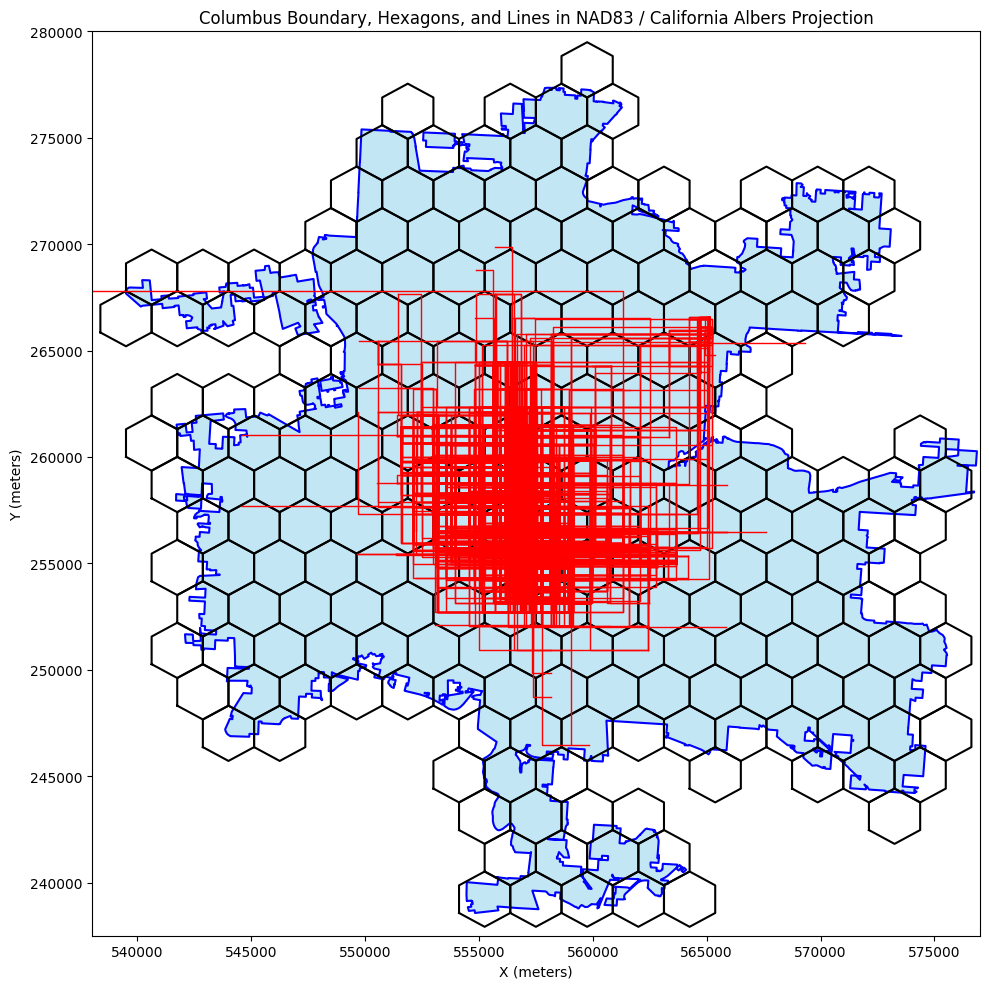

In [21]:
intersect = createIntersections(columbus_bd, columbus_hexagons)
intersect.calculate_intersections()

intersections = intersect.get_intersections()
lines = intersect.get_lines()
line_segments = intersect.get_line_segments()


intersect.plot_map()

Plot the cell and the intersecting segments

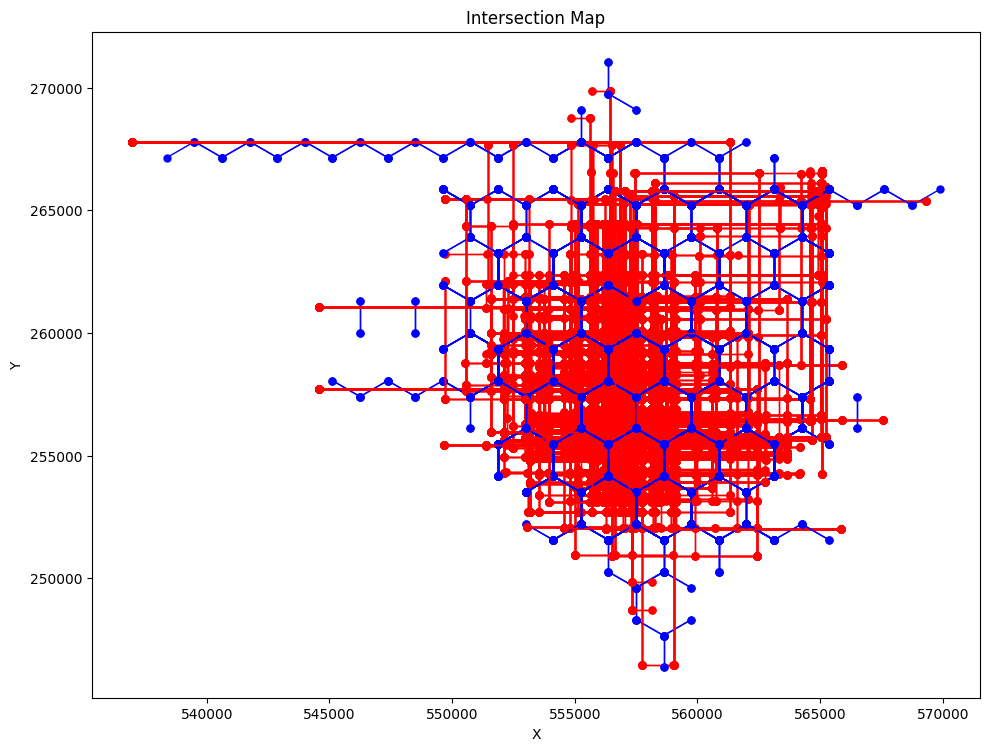

In [22]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the intersections
for intersection in intersections:
    p1, q1, p2, q2 = intersection
    ax.plot([p1[0], q1[0]], [p1[1], q1[1]], 'r-', linewidth=1)
    ax.plot([p2[0], q2[0]], [p2[1], q2[1]], 'b-', linewidth=1)
    ax.plot(p1[0], p1[1], 'ro', markersize=5)
    ax.plot(q1[0], q1[1], 'ro', markersize=5)
    ax.plot(p2[0], p2[1], 'bo', markersize=5)
    ax.plot(q2[0], q2[1], 'bo', markersize=5)

# Set the title and axis labels
ax.set_title('Intersection Map')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Set equal aspect ratio
ax.set_aspect('equal')

# Display the plot
plt.tight_layout()
plt.show()

Calculate averages

In [23]:
# Calculate the total number of intersections
total_intersections = len(intersections)

#count the hexagons
hex_count = 0
for hex in columbus_hexagons:
    hex_count += 1

#calculate the average intersections per hexagin
avg_hex_intersections = total_intersections / hex_count

#print
print(f"Number of Intersections: {total_intersections}")
print(f"Number of Hexagons: {hex_count}")
print(f"Average number of Hexagon intersections: {avg_hex_intersections}")

# Count the number of lines
lines_count = len(lines)

# Calculate the average number of intersections per line
avg_line_intersections = total_intersections / lines_count

#print
print(f"Number of Lines: {lines_count}")
print(f"Average number of Line intersections: {avg_line_intersections}")

seg_count = 0
for segment in line_segments:
    seg_count += 1

#calculate the average intersections per hexagin
avg_seg_intersections = total_intersections / seg_count

#print
print(f"Number of Segments: {seg_count}")
print(f"Average number of Segment intersections: {avg_seg_intersections}")



distances = [row['distance'] for row in results]
distance = 0
for dist in distances:
    distance += dist

avg_line_length = distance / lines_count

print(f"Average length of a Line: {avg_line_length}")


Number of Intersections: 63200
Number of Hexagons: 223
Average number of Hexagon intersections: 283.4080717488789
Number of Lines: 24296
Average number of Line intersections: 2.601251234771156
Number of Segments: 10836016
Average number of Segment intersections: 0.005832401871684206
Average length of a Line: 11195.06743242831


In [24]:
# Initialize a dictionary to count intersections for each hexagon segment
hex_segment_intersections = {}

# Iterate over each hexagon
for hex_coords in columbus_hexagons:
    hex_coords.append(hex_coords[0])  # Close the polygon
    for i in range(len(hex_coords) - 1):
        segment = (tuple(hex_coords[i]), tuple(hex_coords[i + 1]))
        reverse_segment = (tuple(hex_coords[i + 1]), tuple(hex_coords[i]))
        
        if segment not in hex_segment_intersections and reverse_segment not in hex_segment_intersections:
            hex_segment_intersections[segment] = 0

        # Count intersections for this segment
        for inter in intersections:
            if segment == (inter[0], inter[1]) or segment == (inter[1], inter[0]) or \
               segment == (inter[2], inter[3]) or segment == (inter[3], inter[2]) or \
               reverse_segment == (inter[0], inter[1]) or reverse_segment == (inter[1], inter[0]) or \
               reverse_segment == (inter[2], inter[3]) or reverse_segment == (inter[3], inter[2]):
                if segment in hex_segment_intersections:
                    hex_segment_intersections[segment] += 1
                else:
                    hex_segment_intersections[reverse_segment] += 1

# Get the maximum number of intersections
max_intersections = max(hex_segment_intersections.values(), default=0)

# Print the result for debugging
print(f"Max intersections for a hexagon segment: {max_intersections}")


Max intersections for a hexagon segment: 5072


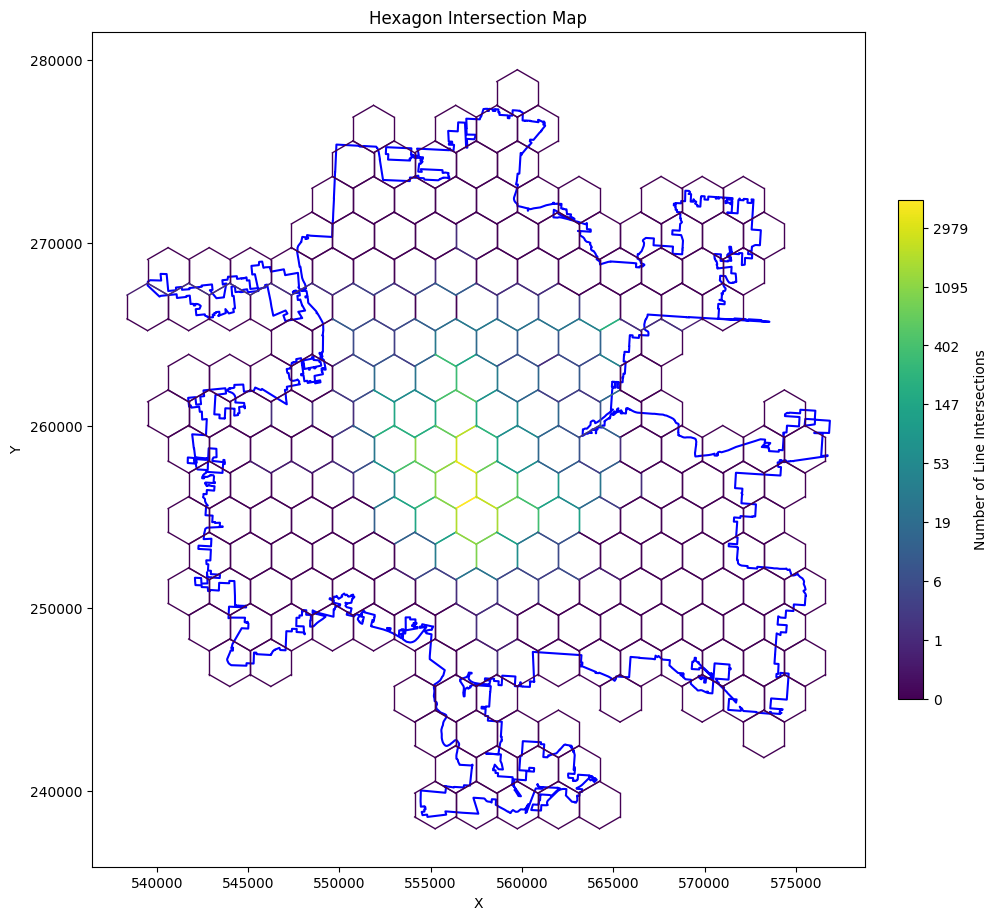

In [25]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Gather plot data
plot_data = []
intersection_counts = []
for hex_coords in columbus_hexagons:
    hex_coords.append(hex_coords[0])  # Close the polygon
    xs, ys = zip(*hex_coords)
    
    for i in range(len(hex_coords) - 1):
        p1 = hex_coords[i]
        p2 = hex_coords[i + 1]
        
        # Find if the segment is in the intersections list
        intersection_count = sum(1 for inter in intersections if 
                                 (tuple(p1), tuple(p2)) in [(inter[0], inter[1]), (inter[1], inter[0]), (inter[2], inter[3]), (inter[3], inter[2])] or 
                                 (tuple(p2), tuple(p1)) in [(inter[0], inter[1]), (inter[1], inter[0]), (inter[2], inter[3]), (inter[3], inter[2])])
        
        
        plot_data.append(((xs[i], xs[i + 1]), (ys[i], ys[i + 1]), intersection_count))
        intersection_counts.append(intersection_count)

xs, ys = zip(*columbus_bd)
plt.plot(xs, ys, 'b-')

# Apply logarithmic scaling to intersection counts for better color differentiation
log_intersection_counts = np.log1p(intersection_counts)  # Use log1p to handle zero counts

# Get the maximum log-transformed intersection count for normalization
max_log_intersections = np.max(log_intersection_counts)

# Plot the hexagon with colored segments using logarithmic color scale
for ((x1, x2), (y1, y2), intersection_count), log_count in zip(plot_data, log_intersection_counts):
    color_value = log_count / max_log_intersections if max_log_intersections > 0 else 0
    ax.plot([x1, x2], [y1, y2], color=cmap(color_value), linewidth=1)

# Set the title and axis labels
ax.set_title('Hexagon Intersection Map')
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Set equal aspect ratio
ax.set_aspect('equal')

# Create a colorbar with logarithmic scale to make the data more visible (due to a high number of low values)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_log_intersections))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)

# Show total counts instead of logarithmic scale
def log_tick_formatter(x, pos):
    return f"{int(np.exp(x) - 1):d}"

cbar.set_label('Number of Line Intersections')
cbar.formatter = FuncFormatter(log_tick_formatter)
cbar.update_ticks()

# Display the plot
plt.tight_layout()
plt.show()
